## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import string
import nltk
import re
from collections import Counter

## 1. Import Data

In [2]:
enron_emails = pd.read_csv('../data/enron_spam_data.csv')

In [3]:
trec_emails = pd.read_csv("../data/trec2007_spam_data_cached.csv")

## 2. Raw Data Processing

### 2.1 Remove Unecessary Columns

In [4]:
enron_emails.drop(['Message ID', 'Date'], axis = 1, inplace = True)

In [5]:
trec_emails.drop(['filepath'], axis = 1, inplace = True)

### 2.2 Drop Missing Values

In [6]:
enron_emails.dropna(subset = ['Message'], inplace = True)
enron_emails.Subject.fillna('None', inplace = True)

In [7]:
trec_emails.dropna(inplace = True)

### 2.3 Create a binary label encoding on Spam/Ham

In [8]:
enron_emails['target'] = enron_emails['Spam/Ham'].map({'ham':0, 'spam':1})

In [9]:
trec_emails['target'] = trec_emails['class'].map({'ham':0, 'spam':1})

## 3. Cleaning Message

- #### Turn words into lowercase letters
- #### Remove numerical digits
- #### Remove punctuation
- #### Tokenization - split a sentence into a list of words 
- #### Remove stopwords - to remove tokens not contributing to the overall meaning of a sentence
- #### Lemmatization - condense variations of the same word to its root form

In [10]:
stopwords = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()

### 3.1 Clean Message into Tokenized Words

In [11]:
def clean_msg_tokenize(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    tokens = re.findall('\S+', text)
    text = [wn.lemmatize(word) for word in tokens if word not in stopwords]
    return text

In [12]:
enron_emails['clean_msg_tokens'] = enron_emails['Message'].apply(lambda x: clean_msg_tokenize(x))

In [13]:
trec_emails['clean_msg_tokens'] = trec_emails['contents'].apply(lambda x: clean_msg_tokenize(x))

### 3.2 Clean Message for N-Grams Vectorization

In [14]:
def clean_msg(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.findall('\S+', text)
    text = " ".join([wn.lemmatize(word) for word in tokens if word not in stopwords])
    return text

In [15]:
enron_emails['cleaned_msg'] = enron_emails['Message'].apply(lambda x: clean_msg(x))

In [16]:
trec_emails['cleaned_msg'] = trec_emails['contents'].apply(lambda x: clean_msg(x))

### 3.3 Remove Extra Stopwords

In [17]:
# Define extra stopwords
# https://github.com/kavgan/stop-words/blob/master/terrier-stop.txt
extra_stopwords = ['c', 'r', 'u', 'let', 'get', 'would', 'please', 'may', 'also', \
                   'like', 'thanks', 'within', 'go', 'inc', 'make', 'could', 'want', \
                   'need', 'new', 'know', 'best', 'e', 'j', 'p', 'b', 'de', 'see', \
                   'take', 'made', 'ect', 'hou', 'com', 'recipient', 'to', 'cc', 'subject', \
                   'http','from','sent', 'fwd', 'www', 'sara', 'shackleton', 'germani', \
                   'sshacklensf', 'cgermannsf', 'also', 'x', 'px', 'utc', 'rev', 'char', \
                   'listhttpsstatethzchmailmanlistinforhelpplease', 'much', 'dont', \
                   'available', 'said']

In [18]:
enron_emails['clean_msg_tokens'] = enron_emails['clean_msg_tokens'].apply(lambda x: [word for word in x if word not in extra_stopwords])

In [19]:
trec_emails['clean_msg_tokens'] = trec_emails['clean_msg_tokens'].apply(lambda x: [word for word in x if word not in extra_stopwords])

### 3.4 Merge Tokenized Words into Cleaned Text

In [20]:
def clean_msg_rm_lst(msg_tokens):
    
    text = ' '.join(msg_tokens)
    return text

In [21]:
enron_emails['clean_msg_no_lst'] = enron_emails['clean_msg_tokens'].apply(lambda x: clean_msg_rm_lst(x))

In [22]:
trec_emails['clean_msg_no_lst'] = trec_emails['clean_msg_tokens'].apply(lambda x: clean_msg_rm_lst(x))

## 4. Vectorization

### 4.1 Combine both datasets

In [23]:
enron_vec = enron_emails[['clean_msg_no_lst', 'target']].copy()
print(enron_vec.shape)

(33345, 2)


In [24]:
trec_vec = trec_emails[['clean_msg_no_lst', 'target']].copy()
print(trec_vec.shape)

(60519, 2)


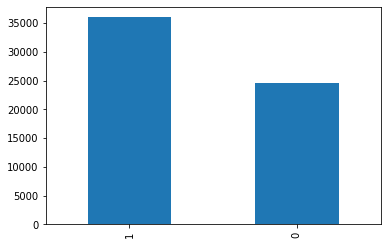

In [25]:
trec_vec['target'].value_counts().plot(kind = 'bar');

In [26]:
# https://python-forum.io/thread-12412.html
# https://www.dataindependent.com/pandas/pandas-sample/
trec_vec = trec_vec.drop(trec_vec.query('target == 1').sample(random_state = 42, frac=.34).index)

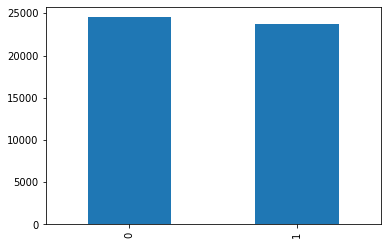

In [27]:
trec_vec['target'].value_counts().plot(kind = 'bar');

In [28]:
# https://riptutorial.com/pandas/example/9811/merging---concatenating---joining-multiple-data-frames--horizontally-and-vertically-
data = pd.concat([enron_vec, trec_vec], ignore_index = True)

### 4.2 Create a Bigram Count Vectors for the Entire Corpus (only run 4.2.1 or 4.2.2 or 4.2.3)

In [29]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

#### 4.2.1 Using Soley the CountVectorizer to Count Term Frequency

In [292]:
# Instantiate CountVectorizer
# Set parameters: bigram only; remove words appear 10 times or less
bigram_vectorizer = CountVectorizer(ngram_range = (2, 2), min_df = 10)

# Generates word counts in documents
corpus_count_vector = bigram_vectorizer.fit(data['clean_msg_no_lst'])

total_features = len(bigram_vectorizer.vocabulary_)
print(total_features)

96616


#### 4.2.2 First: Use CountVectorizer to Count Term Frequency

In [325]:
bigram_vectorizer = CountVectorizer(ngram_range = (2, 2), min_df = 10)
corpus_count_vec = bigram_vectorizer.fit_transform(data['clean_msg_no_lst'])
total_features = len(bigram_vectorizer.vocabulary_)
print(total_features)
print(corpus_count_vec.shape)

96616
(81624, 96616)


#### 4.2.2 Second: Compute IDF values by calling TfidfTransformer on the word counts computed earlier

In [367]:
tfidf_transformer = TfidfTransformer(smooth_idf = True, use_idf = True) 
tfidf_transformer.fit(corpus_count_vec)

TfidfTransformer()

#### 4.2.3 Use Tfidfvectorizer to Compute word counts, idf and tf-idf values

In [30]:
tfidf_vectorizer = TfidfVectorizer(ngram_range = (2, 2), min_df = 10, use_idf = True)
tfidf_vectorizer.fit(data['clean_msg_no_lst'])

TfidfVectorizer(min_df=10, ngram_range=(2, 2))

### 4.3 Train-Test-Split: Enron Data as Train Set & Subset of TREC2007 as Test Set

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
a, X_test, b, Y_test = train_test_split(trec_vec[['clean_msg_no_lst']], trec_vec.target, random_state = 42, test_size = 0.15)

print(f"a shape: {a.shape}")
print(f"b shape: {b.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")

a shape: (41037, 1)
b shape: (41037,)
X_test shape: (7242, 1)
Y_test shape: (7242,)


### 4.4 Apply Bigrams Vectorization to Transform Train & Test Sets (only run 4.4.1 or 4.4.2 or 4.4.3)

#### 4.4.1: Use the Corpus Count Vector from 4.2.1 to Transform Train & Test Sets

In [295]:
X_train_fitted = corpus_count_vector.transform(enron_vec['clean_msg_no_lst'])
X_test_fitted = corpus_count_vector.transform(X_test['clean_msg_no_lst'])
Y_train = enron_vec.target

print(X_train_fitted.shape)
print(Y_train.shape)
print(X_test_fitted.shape)

(33345, 96616)
(33345,)
(7242, 96616)


#### 4.4.2: Use the Corpus Count Vector from 4.2.2 to Transform Train & Test Sets

In [329]:
X_train_vector = bigram_vectorizer.transform(enron_vec['clean_msg_no_lst'])
X_train_fitted = tfidf_transformer.transform(X_train_vector)

X_test_vector = bigram_vectorizer.transform(X_test['clean_msg_no_lst'])
X_test_fitted = tfidf_transformer.transform(X_test_vector)

Y_train = enron_vec.target

print(X_train_fitted.shape)
print(Y_train.shape)
print(X_test_fitted.shape)

(33345, 96616)
(33345,)
(7242, 96616)


#### 4.4.3: Use the Corpus Count Vector from 4.2.3 to Transform Train & Test Sets

In [33]:
X_train_fitted = tfidf_vectorizer.transform(enron_vec['clean_msg_no_lst'])
X_test_fitted = tfidf_vectorizer.transform(X_test['clean_msg_no_lst'])
Y_train = enron_vec.target

print(X_train_fitted.shape)
print(Y_train.shape)
print(X_test_fitted.shape)

(33345, 96616)
(33345,)
(7242, 96616)


## 5. Classification Modeling

In [34]:
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

### 5.1 Random Forest Model

In [382]:
# Manual grid search for random forest 
'''
def explore_rf_params(n_est, depth):
    rf = RandomForestClassifier(n_estimators = n_est, max_depth = depth, n_jobs = -1, random_state = 42)
    rf_model = rf.fit(X_train_fitted, Y_train)
    Y_pred = rf_model.predict(X_test_fitted)
    precision, recall, fscore, support = score(Y_test, Y_pred, pos_label = 1, average = 'binary')
    print(f"Est: {n_est} / Depth: {depth} ---- Precision: {round(precision, 3)} / Recall: {round(recall, 3)} / f1-score: {round(fscore, 3)} / Accuracy: {round((Y_pred==Y_test).sum() / len(Y_pred), 3)}")
    
for n_est in [50, 100, 150]:
    for depth in [10, 20, 30, None]:
        explore_rf_params(n_est, depth)
'''

Est: 50 / Depth: None ---- Precision: 0.51 / Recall: 0.958 / f1-score: 0.666 / Accuracy: 0.528
Est: 100 / Depth: None ---- Precision: 0.51 / Recall: 0.958 / f1-score: 0.666 / Accuracy: 0.528
Est: 150 / Depth: None ---- Precision: 0.509 / Recall: 0.958 / f1-score: 0.665 / Accuracy: 0.526


In [35]:
rf = RandomForestClassifier(n_estimators = 50, max_depth = None, random_state = 42, n_jobs = -1).fit(X_train_fitted, Y_train)

### 5.1.1 Store RF via pickle

In [36]:
# create an iterator object with write permission - model.pkl
with open('../models/rf_pkl', 'wb') as files:
    pickle.dump(rf, files)

In [37]:
# load saved model
with open('../models/rf_pkl' , 'rb') as f:
    rf = pickle.load(f)

### 5.1.2 Use RF for Ham/Spam Predictions

In [38]:
rf_predictions = rf.predict(X_test_fitted)
print(classification_report(Y_test, rf_predictions))
print(confusion_matrix(Y_test, rf_predictions))

              precision    recall  f1-score   support

           0       0.74      0.11      0.20      3691
           1       0.51      0.96      0.67      3551

    accuracy                           0.53      7242
   macro avg       0.62      0.54      0.43      7242
weighted avg       0.63      0.53      0.43      7242

[[ 423 3268]
 [ 150 3401]]


### 5.1.3 RF Confusion Matrix

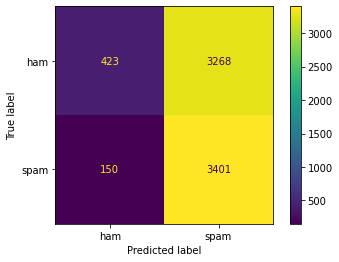

In [39]:
cm_rf = confusion_matrix(Y_test, rf_predictions)
cmd_rf = ConfusionMatrixDisplay(cm_rf, display_labels=['ham','spam'])
cmd_rf.plot();

### 5.1.4 RF ROC Curve

Logistic: ROC AUC=0.685


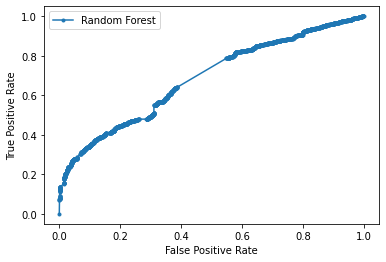

In [82]:
# predict probabilities
rf_probs = rf.predict_proba(X_test_fitted)

# keep probabilities for the positive outcome only
rf_probs = rf_probs[:, 1]
# calculate roc scores
rf_auc = roc_auc_score(Y_test, rf_probs)

# summarize scores
print('Random Forest: ROC AUC=%.3f' % (rf_auc))

# calculate roc curves
rf_fpr, rf_tpr, _ = roc_curve(Y_test, rf_probs)

# plot the roc curve for the model
plt.plot(rf_fpr, rf_tpr, marker='.', label = 'Random Forest')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()

# show the plot
plt.show()

### 5.2 Naive Bayes

In [40]:
mbayes = MultinomialNB().fit(X_train_fitted, Y_train)

### 5.2.1 Store Naive Bayes via pickle

In [41]:
with open('../models/mbayes_pkl', 'wb') as files:
    pickle.dump(mbayes, files)

In [42]:
with open('../models/mbayes_pkl' , 'rb') as f:
    mbayes = pickle.load(f)

### 5.2.2 Use Naive Bayes for Ham/Spam Predictions

In [43]:
mbayes_predictions = mbayes.predict(X_test_fitted)
print(classification_report(Y_test, mbayes_predictions))
print(confusion_matrix(Y_test, mbayes_predictions))

              precision    recall  f1-score   support

           0       0.77      0.79      0.78      3691
           1       0.78      0.76      0.77      3551

    accuracy                           0.78      7242
   macro avg       0.78      0.78      0.78      7242
weighted avg       0.78      0.78      0.78      7242

[[2923  768]
 [ 849 2702]]


### 5.2.3 Naive Bayes Confusion Matrix

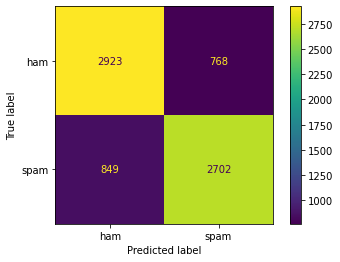

In [44]:
cm_mbayes = confusion_matrix(Y_test, mbayes_predictions)
cmd_mbayes = ConfusionMatrixDisplay(cm_mbayes, display_labels=['ham','spam'])
cmd_mbayes.plot();

### 5.2.4 Naive Bayes ROC Curve

Naive Bayes: ROC AUC=0.849


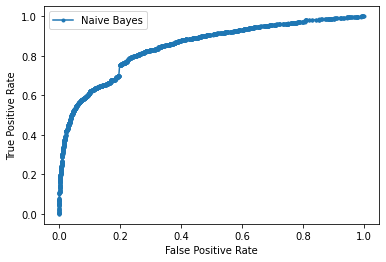

In [83]:
# predict probabilities
mbayes_probs = mbayes.predict_proba(X_test_fitted)

# keep probabilities for the positive outcome only
mbayes_probs = mbayes_probs[:, 1]
# calculate roc scores
mbayes_auc = roc_auc_score(Y_test, mbayes_probs)

# summarize scores
print('Naive Bayes: ROC AUC=%.3f' % (mbayes_auc))

# calculate roc curves
mbayes_fpr, mbayes_tpr, _ = roc_curve(Y_test, mbayes_probs)

# plot the roc curve for the model
plt.plot(mbayes_fpr, mbayes_tpr, marker='.', label = 'Naive Bayes')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()

# show the plot
plt.show()

### 5.3 Logistic Regression

In [45]:
lr = LogisticRegression().fit(X_train_fitted, Y_train)

### 5.3.1 Store Logistic Regression via pickle

In [46]:
with open('../models/lr_pkl', 'wb') as files:
    pickle.dump(lr, files)

In [47]:
with open('../models/lr_pkl' , 'rb') as f:
    lr = pickle.load(f)

### 5.3.2 Use Logistic Regression for Ham/Spam Predictions

In [48]:
lr_predictions = lr.predict(X_test_fitted)
print(classification_report(Y_test, lr_predictions))
print(confusion_matrix(Y_test, lr_predictions))

              precision    recall  f1-score   support

           0       0.82      0.09      0.16      3691
           1       0.51      0.98      0.67      3551

    accuracy                           0.52      7242
   macro avg       0.67      0.53      0.41      7242
weighted avg       0.67      0.52      0.41      7242

[[ 316 3375]
 [  68 3483]]


### 5.3.3 Logistic Regression Confusion Matrix

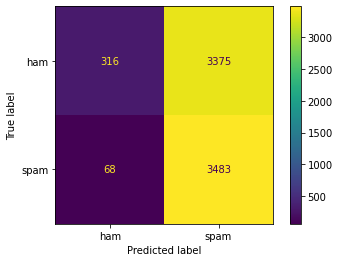

In [49]:
cm_lr = confusion_matrix(Y_test, lr_predictions)
cmd_lr = ConfusionMatrixDisplay(cm_lr, display_labels=['ham','spam'])
cmd_lr.plot();

### 5.3.4 Logistic Regression ROC Curve

Logistic Regression: ROC AUC=0.776


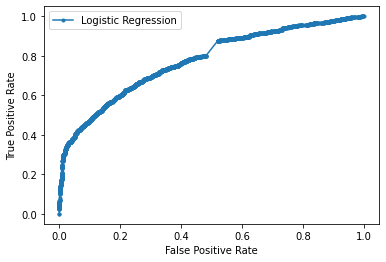

In [84]:
# predict probabilities
lr_probs = lr.predict_proba(X_test_fitted)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate roc scores
lr_auc = roc_auc_score(Y_test, lr_probs)

# summarize scores
print('Logistic Regression: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(Y_test, lr_probs)

# plot the roc curve for the model
plt.plot(lr_fpr, lr_tpr, marker='.', label = 'Logistic Regression')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()

# show the plot
plt.show()

### 5.4 SVM

In [86]:
svm_SVC = svm.SVC(kernel = 'rbf', gamma = 0.01, probability = True).fit(X_train_fitted, Y_train)

### 5.4.1 Store SVM via pickle

In [87]:
with open('../models/svm_pkl', 'wb') as files:
    pickle.dump(svm_SVC, files)

In [88]:
with open('../models/svm_pkl' , 'rb') as f:
    svm_SVC = pickle.load(f)

### 5.4.2 Use SVM for Ham/Spam Predictions

In [89]:
svm_SVC_predictions = svm_SVC.predict(X_test_fitted)
print(classification_report(Y_test, svm_SVC_predictions))
print(confusion_matrix(Y_test, svm_SVC_predictions))

              precision    recall  f1-score   support

           0       0.95      0.01      0.02      3691
           1       0.49      1.00      0.66      3551

    accuracy                           0.50      7242
   macro avg       0.72      0.51      0.34      7242
weighted avg       0.73      0.50      0.33      7242

[[  41 3650]
 [   2 3549]]


### 5.4.3 SVM Confusion Matrix

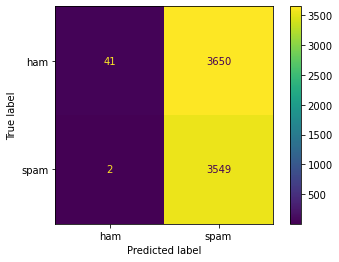

In [90]:
cm_svm = confusion_matrix(Y_test, svm_SVC_predictions)
cmd_svm = ConfusionMatrixDisplay(cm_svm, display_labels=['ham','spam'])
cmd_svm.plot();

### 5.4.4 SVM ROC Curve

SVM: ROC AUC=0.778


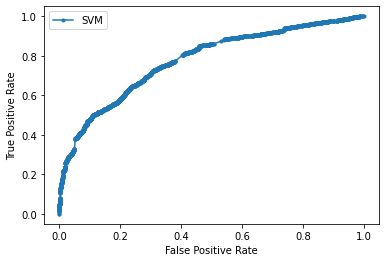

In [91]:
# predict probabilities
# https://www.discoverbits.in/371/sklearn-attributeerror-predict_proba-available-probability
svm_probs = svm_SVC.predict_proba(X_test_fitted)

# keep probabilities for the positive outcome only
svm_probs = svm_probs[:, 1]

# calculate roc scores
svm_auc = roc_auc_score(Y_test, svm_probs)

# summarize scores
print('SVM: ROC AUC=%.3f' % (svm_auc))

# calculate roc curves
svm_fpr, svm_tpr, _ = roc_curve(Y_test, svm_probs)

# plot the roc curve for the model
plt.plot(svm_fpr, svm_tpr, marker='.', label = 'SVM')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()

# show the plot
plt.show()

### 5.5 KNN

In [75]:
knn = KNeighborsClassifier(n_neighbors = 5).fit(X_train_fitted, Y_train)

### 5.5.1 Store KNN via pickle

In [76]:
with open('../models/knn_pkl', 'wb') as files:
    pickle.dump(knn, files)

In [77]:
with open('../models/knn_pkl' , 'rb') as f:
    knn = pickle.load(f)

### 5.5.2 Use KNN for Ham/Spam Predictions

In [78]:
knn_predictions = knn.predict(X_test_fitted)
print(confusion_matrix(Y_test, knn_predictions))
print(classification_report(Y_test, knn_predictions))

[[ 382 3309]
 [ 301 3250]]
              precision    recall  f1-score   support

           0       0.56      0.10      0.17      3691
           1       0.50      0.92      0.64      3551

    accuracy                           0.50      7242
   macro avg       0.53      0.51      0.41      7242
weighted avg       0.53      0.50      0.40      7242



### 5.5.3 KNN Confusion Matrix

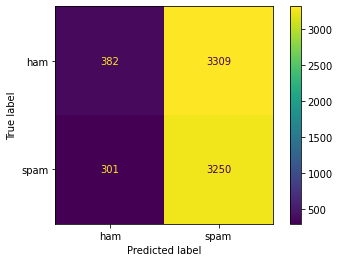

In [79]:
cm_knn = confusion_matrix(Y_test, knn_predictions)
cmd_knn = ConfusionMatrixDisplay(cm_knn, display_labels=['ham','spam'])
cmd_knn.plot();

### 5.5.4 KNN ROC Curve¶

KNN: ROC AUC=0.502


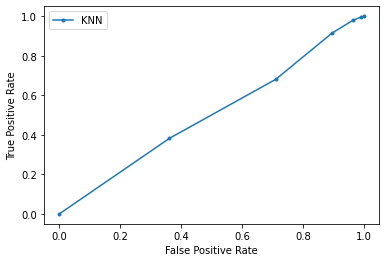

In [92]:
# https://www.discoverbits.in/371/sklearn-attributeerror-predict_proba-available-probability
knn_probs = knn.predict_proba(X_test_fitted)

# keep probabilities for the positive outcome only
knn_probs = knn_probs[:, 1]

# calculate roc scores
knn_auc = roc_auc_score(Y_test, knn_probs)

# summarize scores
print('KNN: ROC AUC=%.3f' % (knn_auc))

# calculate roc curves
knn_fpr, knn_tpr, _ = roc_curve(Y_test, knn_probs)

# plot the roc curve for the model
plt.plot(knn_fpr, knn_tpr, marker='.', label = 'KNN')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()

# show the plot
plt.show()